In [28]:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings

import pandas as pd
import numpy as np
import yfinance as yf

from pypfopt.expected_returns import ema_historical_return
from pypfopt.risk_models import exp_cov, fix_nonpositive_semidefinite, CovarianceShrinkage

from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from utils import Nasdaq100

## Global Settings

In [2]:
seed = 1227
rs = np.random.RandomState(seed)

mpl.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)

warnings.filterwarnings('ignore')

sixteen_months_ago = (pd.to_datetime('today') - pd.DateOffset(months=16)).strftime('%Y-%m-%d')
five_years_sixteen_months_ago = (pd.to_datetime(sixteen_months_ago) - pd.DateOffset(years=5)).strftime('%Y-%m-%d')

sixteen_months_ago, five_years_sixteen_months_ago

('2021-11-01', '2016-11-01')

## Data

Our investment horizon is 16 months. We will choose the periodicity to be daily prices, using five years of historical daily closing prices as a starting point for portfolio optimization. For out of sample, we will use the last 16 months of data (counting from today) to evaluate the performance of the portfolio. This time frame is long enough to capture a variety of market conditions and reduce the impact of short-term fluctuations, but not so long that it becomes difficult to identify meaningful patterns or trends in the data.

In [3]:

# Nasdaq 100
nasdaq100_mapping = {
    'AAPL': 'Apple Inc.',
    'ABBV': 'AbbVie Inc.',
    'ABMD': 'Abiomed Inc.',
    'ACN': 'Accenture plc',
    'ADBE': 'Adobe Inc.',
    'ADI': 'Analog Devices Inc.',
    'ADP': 'Automatic Data Processing Inc.',
    'ADSK': 'Autodesk Inc.',
    'AEP': 'American Electric Power Company Inc.',
    'ALGN': 'Align Technology Inc.',
    'AMAT': 'Applied Materials Inc.',
    'AMD': 'Advanced Micro Devices Inc.',
    'AMGN': 'Amgen Inc.',
    'AMZN': 'Amazon.com Inc.',
    'ANSS': 'ANSYS Inc.',
    'ANTM': 'Anthem Inc.',
    'ASML': 'ASML Holding NV',
    'ATVI': 'Activision Blizzard Inc.',
    'AVGO': 'Broadcom Inc.',
    'BIDU': 'Baidu Inc.',
    'BIIB': 'Biogen Inc.',
    'BKNG': 'Booking Holdings Inc.',
    'BMRN': 'BioMarin Pharmaceutical Inc.',
    'BMY': 'Bristol-Myers Squibb Company',
    'CDNS': 'Cadence Design Systems Inc.',
    'CDW': 'CDW Corp.',
    'CERN': 'Cerner Corp.',
    'CHKP': 'Check Point Software Technologies Ltd.',
    'CHTR': 'Charter Communications Inc.',
    'CMCSA': 'Comcast Corp.',
    'CME': 'CME Group Inc.',
    'COST': 'Costco Wholesale Corp.',
    'CSCO': 'Cisco Systems Inc.',
    'CSX': 'CSX Corp.',
    'CTAS': 'Cintas Corp.',
    'CTSH': 'Cognizant Technology Solutions Corp.',
    'CTXS': 'Citrix Systems Inc.',
    'DISCA': 'Discovery Inc. Class A',
    'DISCK': 'Discovery Inc. Class C',
    'DISH': 'DISH Network Corp.',
    'DLTR': 'Dollar Tree Inc.',
    'DOCU': 'DocuSign Inc.',
    'DOGE-USD': 'Dogecoin',
    'DXCM': 'DexCom Inc.',
    'EA': 'Electronic Arts Inc.',
    'EBAY': 'eBay Inc.',
    'EXC': 'Exelon Corp.',
    'EXPE': 'Expedia Group Inc.',
    'META': 'Meta Platforms Inc.',
    'FAST': 'Fastenal Co.',
    'FISV': 'Fiserv Inc.',
    'FOX': 'Fox Corporation Class B',
    'FOXA': 'Fox Corporation Class A',
    'GILD': 'Gilead Sciences Inc.',
    'GOOG': 'Alphabet Inc. Class C',
    'GOOGL': 'Alphabet Inc. Class A',
    'GRMN': 'Garmin Ltd.',
    'GILD': 'Gilead Sciences Inc.',
    'HD': 'Home Depot Inc.',
    'HON': 'Honeywell International Inc.',
    'IDXX': 'IDEXX Laboratories Inc.',
    'ILMN': 'Illumina Inc.',
    'INCY': 'Incyte Corp.',
    'INTC': 'Intel Corp.',
    'INTU': 'Intuit Inc.',
    'ISRG': 'Intuitive Surgical Inc.',
    'JD': 'JD.com Inc.',
    'JPM': 'JPMorgan Chase & Co.',
    'KDP': 'Keurig Dr Pepper Inc.',
    'KHC': 'Kraft Heinz Co.',
    'KLAC': 'KLA Corp.',
    'LBTYA': 'Liberty Global plc Class A',
    'LBTYK': 'Liberty Global plc Class C',
    'LRCX': 'Lam Research Corp.',
    'LULU': 'Lululemon Athletica Inc.',
    'MAR': 'Marriott International Inc.',
    "MAR": "Marriott International Inc",
    "MCHP": "Microchip Technology Inc",
    "MDLZ": "Mondelez International Inc",
    "MELI": "MercadoLibre Inc",
    "MNST": "Monster Beverage Corp",
    "MSFT": "Microsoft Corp",
    "MU": "Micron Technology Inc",
    "MXIM": "Maxim Integrated Products Inc",
    "NFLX": "Netflix Inc",
    "NTES": "NetEase Inc",
    "NVDA": "NVIDIA Corp",
    "NXPI": "NXP Semiconductors NV",
    "ORLY": "O'Reilly Automotive Inc",
    "PAYX": "Paychex Inc",
    "PCAR": "PACCAR Inc",
    "PDD": "Pinduoduo Inc",
    "PEP": "PepsiCo Inc",
    "PFE": "Pfizer Inc",
    "PKG": "Packaging Corp of America",
    "PYPL": "PayPal Holdings Inc",
    "QCOM": "QUALCOMM Inc",
    "REGN": "Regeneron Pharmaceuticals Inc",
    "ROST": "Ross Stores Inc",
    "SBUX": "Starbucks Corp",
    "SGEN": "Seagen Inc",
    "SIRI": "Sirius XM Holdings Inc",
    "SNPS": "Synopsys Inc",
    "SPLK": "Splunk Inc",
    "SWKS": "Skyworks Solutions Inc",
    "TCOM": "Trip.com Group Ltd",
    "TEAM": "Atlassian Corporation Plc",
    "TSLA": "Tesla Inc",
    "TXN": "Texas Instruments Inc",
    "VRSK": "Verisk Analytics Inc",
    "VRTX": "Vertex Pharmaceuticals Inc",
    "WBA": "Walgreens Boots Alliance Inc",
    "WDAY": "Workday Inc",
    "XEL": "Xcel Energy Inc",
    "XLNX": "Xilinx Inc",
    "ZM": "Zoom Video Communications Inc"
}

# Hand-picked
symbols = [
    'AAPL', 'AMZN', 'GOOG', 'MSFT', 'META', 'TSLA', 'NVDA', 'PYPL', 'NFLX', 'LULU', 
    'COST', 'EBAY', 'EA', 'INTC', 'PFE', 'PEP', 'HON', 'XEL', 'CMCSA', 'JPM', 
    'CME', 'HD', 'QCOM', 'SBUX', 'TXN', 'ORLY', 'CSCO', 'VRTX', 'WDAY', 'BIIB'
]

len(set(symbols))

30

In [4]:
# Download data from Yahoo Finance for the last 5 years
asset_data = yf.download(
  tickers = ' '.join(symbols), 
  start = five_years_sixteen_months_ago
)['Adj Close']
# Examine the first 5 rows
asset_data.head(n = 5)

[*********************100%***********************]  30 of 30 completed


,AAPL,AMZN,BIIB,CMCSA,CME,COST,CSCO,EA,EBAY,GOOG,...,PEP,PFE,PYPL,QCOM,SBUX,TSLA,TXN,VRTX,WDAY,XEL
Date,,,,,,,,,,,,,,,,,,,,,
2016-11-01,25.911686,39.270500,282.559998,26.939901,78.421150,129.430557,25.092976,76.784149,26.754290,39.180500,...,89.062462,23.197977,41.540001,56.722897,46.107685,12.719333,58.422142,77.879997,84.959999,34.109928
2016-11-02,25.934925,38.278000,277.260010,26.948669,79.641083,129.483688,25.018885,78.046806,26.641165,38.435001,...,89.062462,22.869457,41.349998,55.685383,46.529251,12.534667,57.917339,78.000000,83.099998,33.776020
2016-11-03,25.656940,38.351501,273.489990,26.720703,81.073502,127.872543,24.961256,79.427788,26.452623,38.106499,...,88.995689,22.316948,41.189999,55.569176,45.466572,12.494667,57.544453,77.690002,83.000000,33.909580
2016-11-04,25.425669,37.752499,277.000000,26.593563,80.947578,125.916183,24.854229,79.131882,26.348928,38.101002,...,88.311302,22.399080,40.900002,55.386566,46.327240,12.704000,57.290192,78.959999,82.769997,33.692535
2016-11-07,25.792429,39.246498,295.619995,26.966206,82.482315,127.067009,25.471676,79.980209,26.622311,39.125999,...,89.271118,22.682798,41.279999,56.822479,47.855389,12.880667,58.485153,83.220001,85.589996,34.352024


In [5]:
# Check for missing values
assert asset_data.isna().any().sum() == 0

### In-sample and Out-of-sample Split

First, we split the data into in-sample for the optimization and out-sample for evaluating the performance.

In [7]:
in_sample_data = asset_data.loc[:sixteen_months_ago]
out_sample_data = asset_data.loc[sixteen_months_ago:]

In [8]:
# Max and min dates of the in-sample data
in_sample_data.index.min(), in_sample_data.index.max()

# Number of observations (trading days) in the in-sample data
in_sample_data.shape[0]

(Timestamp('2016-11-01 00:00:00'), Timestamp('2021-11-01 00:00:00'))

1259

In [9]:
# Max and min dates of the out-of-sample data
out_sample_data.index.min(), out_sample_data.index.max()

# Number of observations (trading days) in the out-of-sample data
out_sample_data.shape[0]

(Timestamp('2021-11-01 00:00:00'), Timestamp('2023-03-01 00:00:00'))

334

Write the data to disk:

In [10]:
out_sample_data.to_parquet('../data/out_sample_data.parquet')
in_sample_data.to_parquet('../data/in_sample_data.parquet')

### EDA

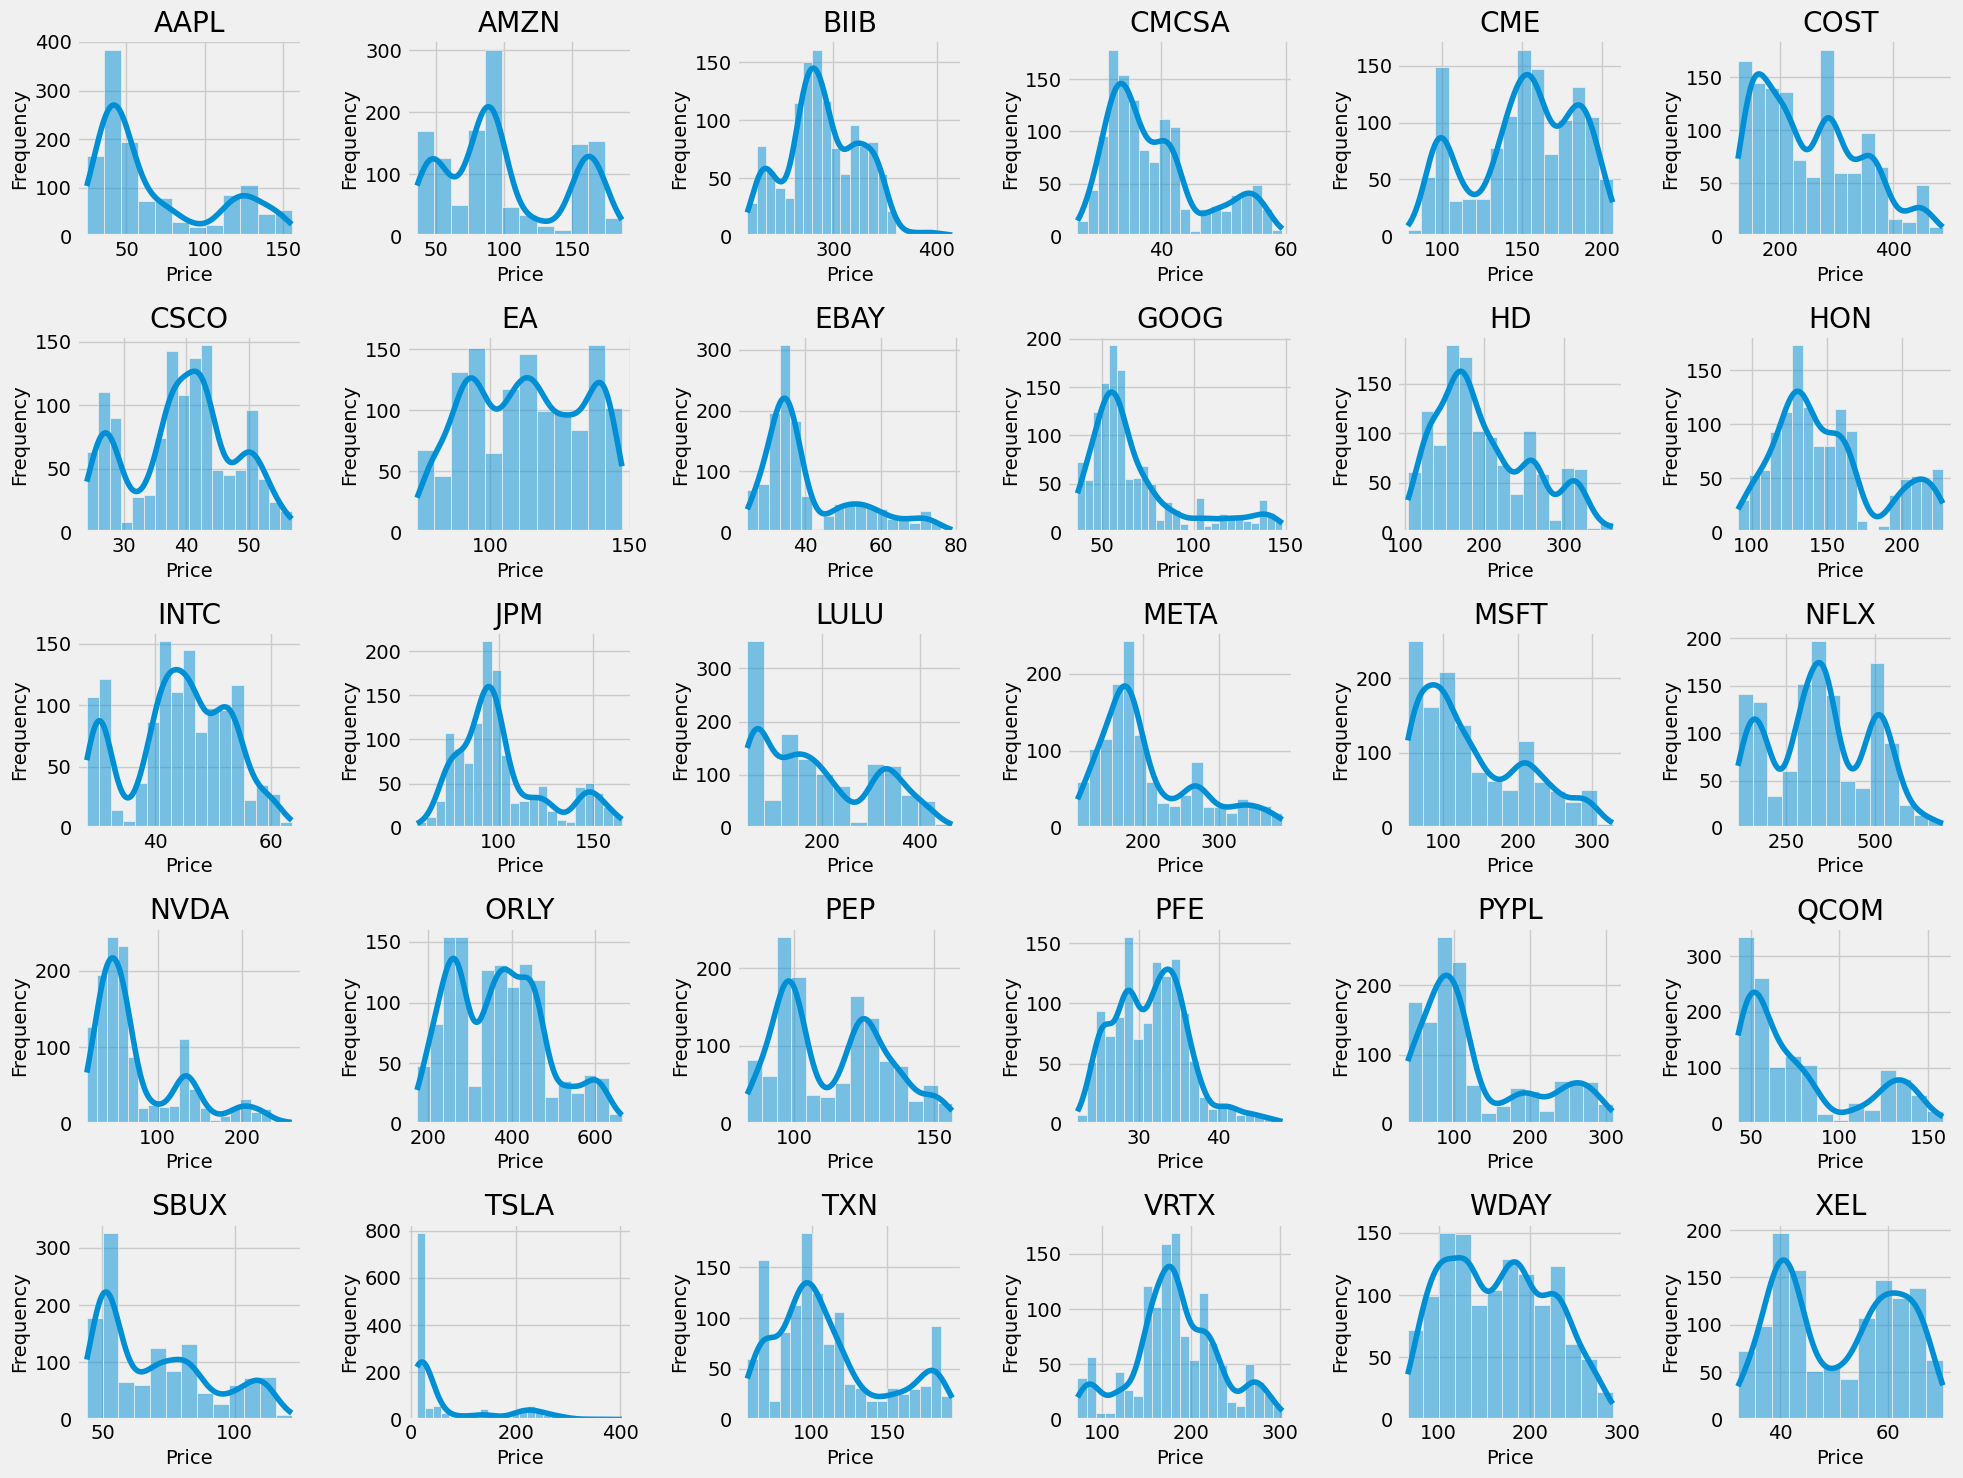

In [12]:
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(20, 15))

# Flatten the axes array
axes = axes.flatten()

for i, col in enumerate(in_sample_data.columns):
    ax = axes[i]
    sns.histplot(in_sample_data[col], kde=True, ax=ax)
    ax.set_title(col)
    ax.set_xlabel('Price')
    ax.set_ylabel('Frequency')

fig.tight_layout()

# display the plot
plt.show();

Next, we will apply PCA to the 30 dimensional data matrix to further explore the intrinsic dimensionality of the matrix. We build a pipeline as follows:

In [18]:
pca_pipeline = Pipeline([('power_transformer', PowerTransformer(method='yeo-johnson', standardize=True)), ('pca', PCA(n_components=30))])

pca_pipeline.fit(in_sample_data)

Pipeline(steps=[('power_transformer', PowerTransformer()),
                ('pca', PCA(n_components=30))])

We can plot the scree plot to examine the effectiveness of PCA:

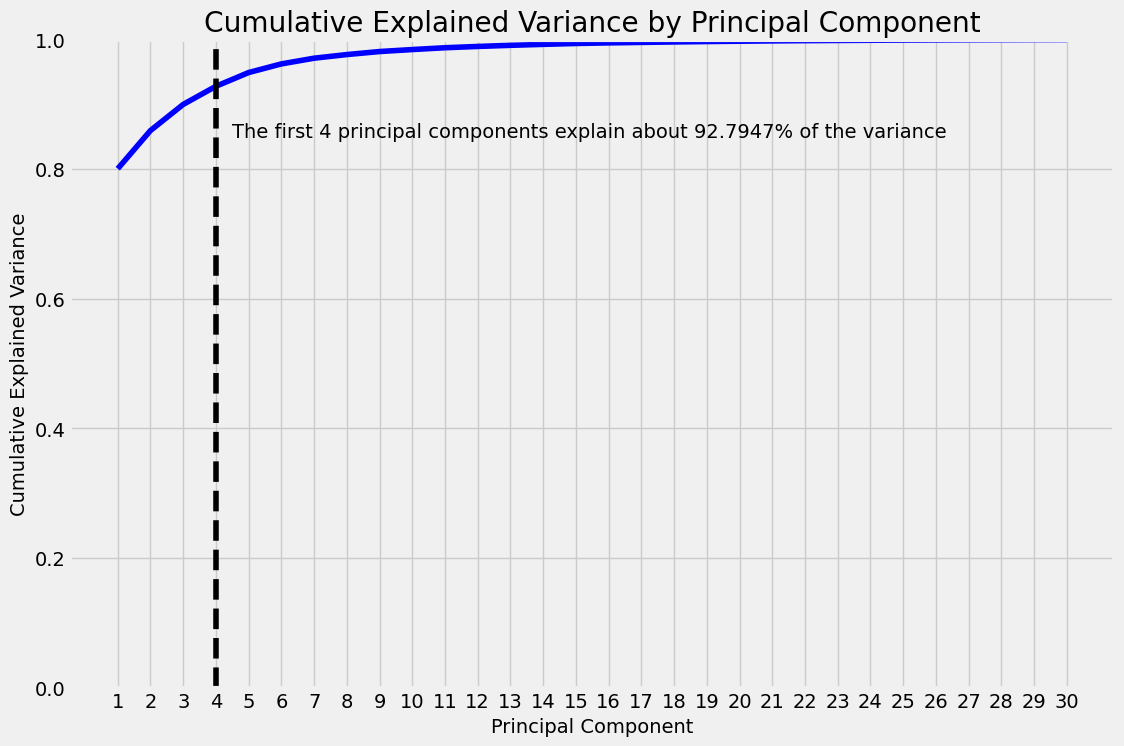

In [19]:
# Cumulative explained variance
cum_exp_var = np.cumsum(pca_pipeline['pca'].explained_variance_ratio_)
pc_indices = range(1, pca_pipeline['pca'].n_components + 1)
# Number of principal components that explain 90% of the variance
num_pc_90 = sum(cum_exp_var <= 0.90) + 1

plt.plot(pc_indices, cum_exp_var, color='blue')
plt.ylim(0, 1)
plt.xticks(pc_indices)
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.axvline(x=num_pc_90, color='black', linestyle='--')
plt.text(num_pc_90 + 0.5, 0.85, f'The first {num_pc_90} principal components explain about {round(cum_exp_var[num_pc_90 - 1] * 100, 4)}% of the variance', color='black')
plt.title('Cumulative Explained Variance by Principal Component')
plt.show();

On the other hand:

In [20]:
# First two principal components
cum_exp_var[:2]

array([0.8007251, 0.859642 ])

We can plot the first two principal components and examine the factor loadings. These are the eigenvectors of the optimization problem:

In [21]:
pcs = pd.DataFrame(pca_pipeline.transform(in_sample_data), columns=[f'PC{i}' for i in range(1, pca_pipeline['pca'].n_components + 1)])
pcs

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
0,9.788984,0.727996,0.836305,0.882210,-0.510218,-0.981116,1.242949,-0.857726,-0.473627,-0.365571,...,0.009911,0.012225,0.175007,-0.298306,0.078675,0.093015,0.107591,-0.116331,0.048968,-0.015477
1,9.898362,0.789399,0.956977,0.908185,-0.418110,-0.921830,1.273650,-0.848119,-0.471508,-0.281354,...,0.007631,0.007121,0.166914,-0.299811,-0.004651,0.034082,0.089750,-0.079010,0.035237,-0.015536
2,10.082121,0.816473,1.030908,0.987594,-0.315966,-0.893048,1.369232,-0.784545,-0.481867,-0.242255,...,0.101141,-0.006325,0.180345,-0.347299,-0.062440,0.005296,0.110659,-0.073511,0.031024,0.003483
3,10.125112,0.772598,0.974796,1.026691,-0.371280,-0.929374,1.350299,-0.823733,-0.448373,-0.261082,...,0.102259,0.028876,0.138505,-0.324945,-0.104705,0.019779,0.135365,-0.066870,-0.010121,0.007256
4,9.712225,0.556778,0.617728,0.951913,-0.654731,-0.782298,1.254342,-0.870493,-0.464728,-0.419673,...,0.144063,0.063495,0.102935,-0.257711,-0.096455,0.064803,0.088186,-0.077496,-0.046307,0.023592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,-8.657003,0.242270,0.020855,-1.657445,-0.054236,-1.075097,0.446602,0.125678,-0.056029,0.956466,...,0.400304,0.192116,-0.014533,0.070519,-0.001364,-0.172270,0.102561,0.023835,-0.088694,-0.012705
1255,-8.526856,0.388539,0.241663,-1.654139,0.113357,-1.152787,0.531589,0.167366,-0.023797,1.020120,...,0.472580,0.229227,0.025804,0.047886,-0.035679,-0.056534,0.085057,0.055079,-0.062333,0.056011
1256,-8.597354,0.337071,0.104839,-1.591755,0.082227,-1.124339,0.479735,0.265378,-0.042364,0.952244,...,0.428570,0.238953,0.002320,0.092446,-0.062573,-0.033438,0.076334,0.042930,-0.098169,0.038095
1257,-8.679186,0.265307,0.009727,-1.525639,0.157779,-1.112509,0.450978,0.232868,-0.053907,0.957323,...,0.428656,0.251319,0.011123,0.063231,-0.024884,0.004802,0.179601,0.033757,-0.092984,0.063011


In [22]:
loadings = pd.DataFrame(pca_pipeline['pca'].components_.T[:, :2], columns=['PC ' + str(i) for i in range(1, 3)], index=in_sample_data.columns)
loadings

,PC 1,PC 2
AAPL,-0.199119,-0.094774
AMZN,-0.198243,-0.057063
BIIB,0.011336,-0.430773
CMCSA,-0.175091,0.118988
CME,-0.176791,0.238405
COST,-0.199181,0.071525
CSCO,-0.169766,0.241039
EA,-0.136281,-0.494871
EBAY,-0.172082,-0.199174
GOOG,-0.200706,-0.079075


These are the loadings--- how much each stock price series contributes to the first two principal components. To find out the top five stocks that contributed the most to each of the principal components:

In [23]:
loadings.apply(lambda col: np.abs(col)).sort_values(by='PC 1', ascending=False).iloc[:5, 0]

MSFT    0.202005
HD      0.201783
PYPL    0.201266
TXN     0.200863
GOOG    0.200706
Name: PC 1, dtype: float64

In [24]:
loadings.apply(lambda col: np.abs(col)).sort_values(by='PC 2', ascending=False).iloc[:5, 1]

EA      0.494871
BIIB    0.430773
TSLA    0.304193
NVDA    0.282613
CSCO    0.241039
Name: PC 2, dtype: float64

We plot the scatter plot of the first two principal components as follows:

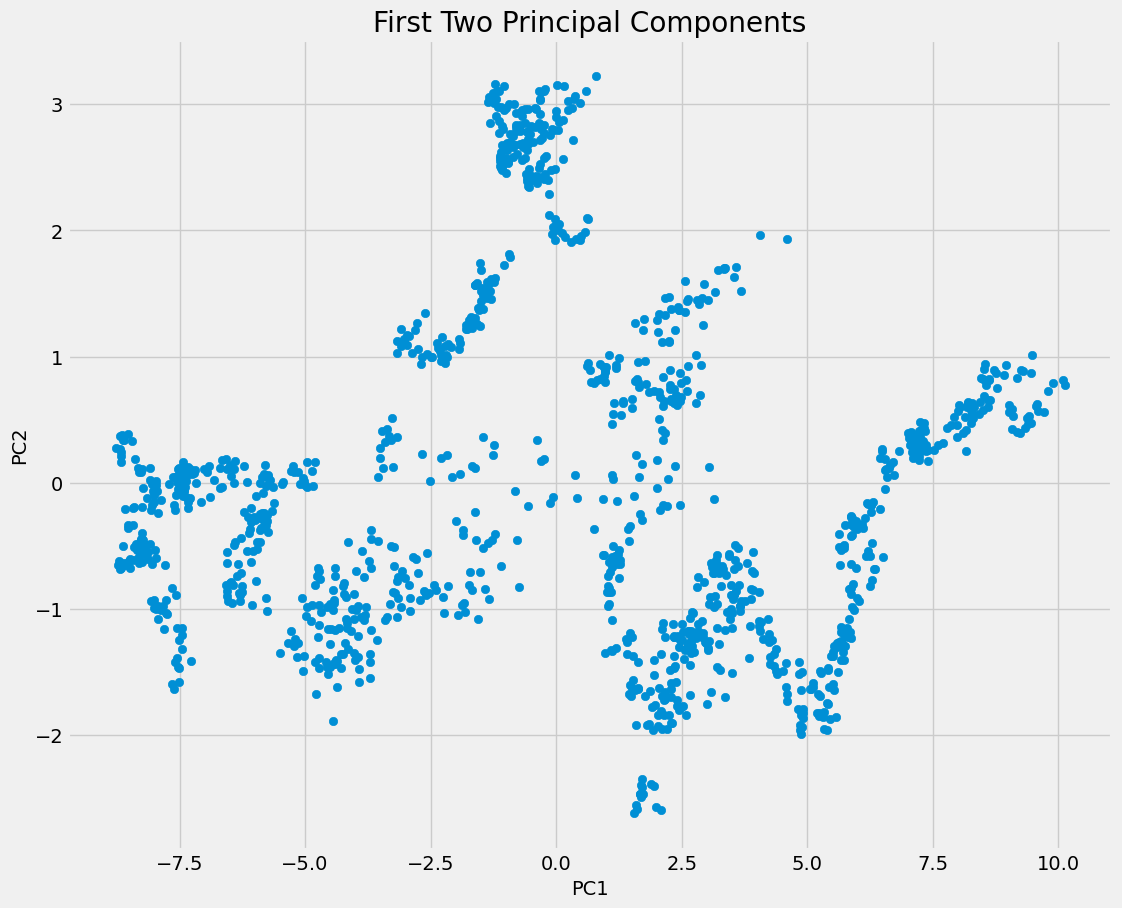

In [25]:
# Plot the first two principal components
fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(pcs['PC1'], pcs['PC2'])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('First Two Principal Components')
plt.show();

Using TSNE:

In [26]:
tsne_mapping = TSNE(n_components=2, perplexity=100, learning_rate='auto', random_state=seed).fit_transform(pcs)

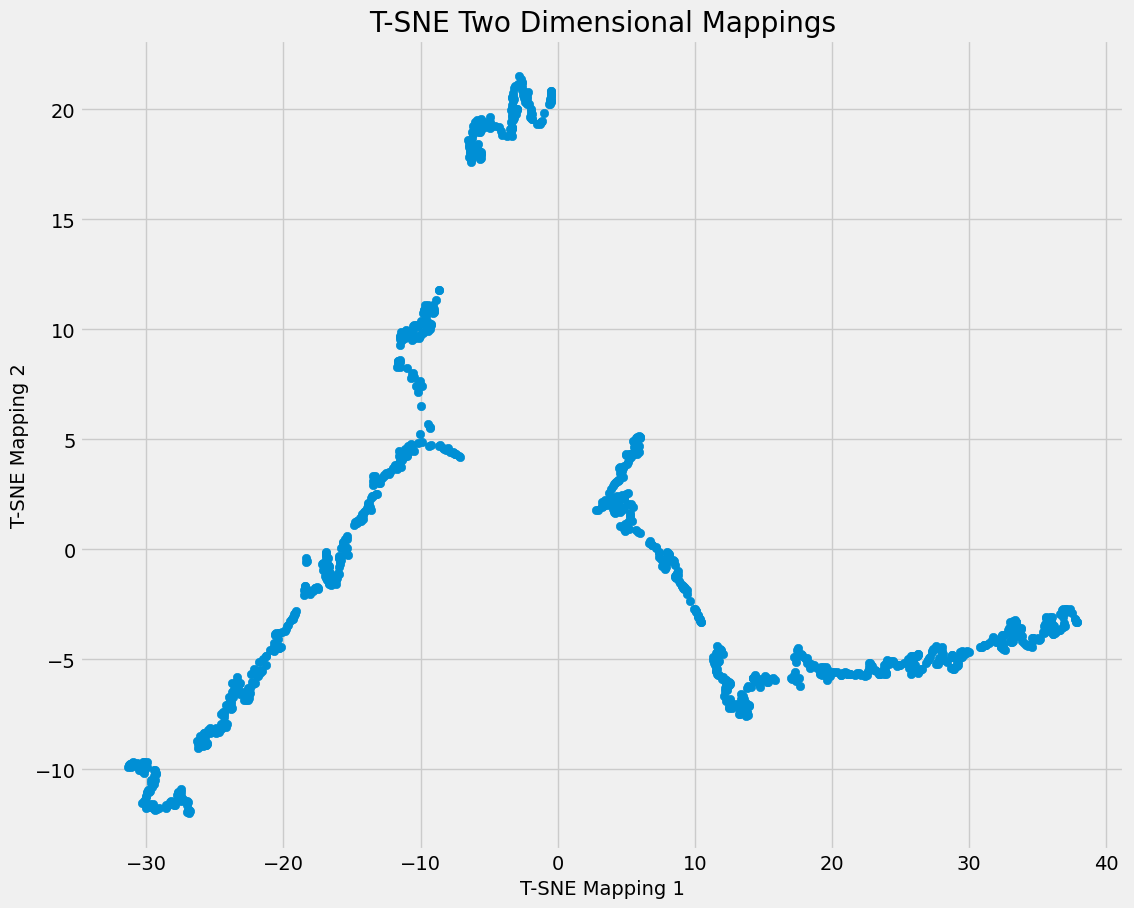

In [27]:
# Plot the first two t-SNE components
fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(tsne_mapping[:, 0], tsne_mapping[:, 1])
ax.set_xlabel('T-SNE Mapping 1')
ax.set_ylabel('T-SNE Mapping 2')
ax.set_title('T-SNE Two Dimensional Mappings')
plt.show();

## Exponentially Weighted Moving Expected Returns

The mean-variance optimization requires knowledge of the expected returns. For our purposes, we will use the exponentially-weighted mean of (daily) historical returns. The exponentially weighted moving average (EWMA) is an approach such that older observations are given lower weights compared to more recent observations, and the weights decrease exponentially over time. In `PyPortfolioOpt`'s implementation, the hyperparameter to tune is the `span`, which is the time-span for the EMA. This gives us the ability to decide exactly how much more weight is given to recent data. Generally, it is advisable to use a higher span – in the limit, this tends towards the mean historical return.

The EMA captures the intuition that recent prices are (exponentially) more relevant than previous prices. If we let $p_0$ denote today's price, $p_1$ denote yesterday's price, $p_n$ denote the price $n$ days ago, the exponentially weighted mean is given by:

$$
\alpha\left[p_0+(1-\alpha) p_1+(1-\alpha)^2 p_2+\ldots+(1-\alpha)^n p_n+\ldots\right]
$$

where $\alpha$ parametrizes the decay rate $(0<|\alpha|<1)$: by observation we note that higher $\alpha$ gives more weight to recent results, and lower $\alpha$ causes the exponential mean to tend to the arithmetic mean. Additionally, because $\frac{1}{\alpha}=1+(1-\alpha)+(1-\alpha)^2+\ldots$, we note that the 'weights' sum to one.

In practice, we do not compute the infinite sum above. Rather, observing that the weights rapidly become negligible, we limit the calculation to some window. This window is not to be confused with the `span` of the EMA, which is another way of specifying the decay rate - a good explanation can be found on the [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/window.html#exponentially-weighted-window).

The EMA is useful because it 'reacts' to recent data much better than the SMA owing to the exponential weighting scheme, while still preserving the memory of the time series.

In [13]:
in_sample_returns = ema_historical_return(in_sample_data, returns_data=False, span=500, frequency=252)
in_sample_returns

AAPL     0.480608
AMZN     0.226414
BIIB     0.087247
CMCSA    0.118547
CME      0.218186
COST     0.454537
CSCO     0.228119
EA       0.155317
EBAY     0.497074
GOOG     0.570061
HD       0.409384
HON      0.204530
INTC     0.001344
JPM      0.393707
LULU     0.653634
META     0.293758
MSFT     0.606871
NFLX     0.548231
NVDA     1.342389
ORLY     0.341610
PEP      0.203128
PFE      0.214881
PYPL     0.260220
QCOM     0.282742
SBUX     0.201166
TSLA     2.972910
TXN      0.290732
VRTX    -0.062384
WDAY     0.441893
XEL      0.054729
Name: 2021-11-01 00:00:00, dtype: float64

In [14]:
# Write the in-sample returns to disk
in_sample_returns.to_csv('../data/in_sample_returns.csv')

## Risk Model

In addition to the expected returns, mean-variance optimization requires a risk model, some way of quantifying asset risk. The most commonly-used risk model is the covariance matrix, which describes asset volatilities and their co-dependence. 

The easiest approach is to take two price series (e.g stock prices for AAPL and GOOG), then compute the daily percentage change or log returns, before feeding these into a covariance calculation. This does work and is the standard approach. But this may throw away a good deal of information, because covariance does not preserve the order of observations.

In other words, we will get the same covariance whether we provide $\left(x_2, y_2\right),\left(x_{17}, y_{17}\right),\left(x_8, y_8\right), \ldots$ or $\left(x_1, y_1\right),\left(x_2, y_2\right),\left(x_3, y_3\right), \ldots$.

In the case of time series, the order of the returns is of fundamental importance. Therefore, we need some way of incorporating the sequential nature of the data into the definition of covariance. 

### Exponentially Weighted Covariance Estimator

Fortunately, it is simple to apply our intuition of the EMA to come up with a similar metric for covariance. We will rewrite the definition of covariance portfolio as follows:

$$
\operatorname{Cov}(x, y)=\frac{1}{N}\left[\left(x_1-\bar{x}\right)\left(y_1-\bar{y}\right)+\left(x_2-\bar{x}\right)\left(y_2-\bar{y}\right)+\ldots+\left(x_N-\bar{x}\right)\left(y_N-\bar{y}\right)\right]
$$

Rather than letting $\left(x_i, y_i\right)$ be any observations from the dataset, we will preserve the order by saying that $\left(x_i, y_i\right)$ denotes the returns of asset $X$ and $Y$ $i$ days ago. Thus $\left(x_1-\bar{x}\right)\left(y_1-\bar{y}\right)$ specifically refers to the co-variation of the returns yesterday. We simply give each co-variation term an exponential weight as follows:

$$
\operatorname{Cov}(x, y)=\frac{\alpha}{N}\left[\left(x_1-\bar{x}\right)\left(y_1-\bar{y}\right)+(1-\alpha)\left(x_2-\bar{x}\right)\left(y_2-\bar{y}\right)+\ldots+(1-\alpha)^N\left(x_N-\bar{x}\right)\left(y_N-\bar{y}\right)\right]
$$

Or more simply:

$$
\operatorname{Cov}(x, y)=\frac{\alpha}{N} \sum_{i=1}^N(1-\alpha)^{i-1}\left(x_i-\bar{x}\right)\left(y_i-\bar{y}\right)
$$

This simple procedure is all that is required to incorporate the temporal nature of asset returns into the covariance matrix.

In [15]:
in_sample_cov_exp = exp_cov(in_sample_data, returns_data=False, span=500, frequency=252)

Note that, for optimization reasons, the estimator for the covariance matrix should be positive semidefinite--- a matrix whose eigenvalues are nonnegative. There is a lot of equivalent ways to characterize positive semidefiniteness. For our purposes, it is important since the volatility measure should be non-negative. Below, we check if a covariance matrix is positive semidefinite, and if not, fix it with the 'spectral' method. It sets negative eigenvalues to zero and rebuilds the matrix.

In [16]:
in_sample_cov_exp = fix_nonpositive_semidefinite(in_sample_cov_exp)
in_sample_cov_exp.style.background_gradient(cmap='coolwarm')

,AAPL,AMZN,BIIB,CMCSA,CME,COST,CSCO,EA,EBAY,GOOG,HD,HON,INTC,JPM,LULU,META,MSFT,NFLX,NVDA,ORLY,PEP,PFE,PYPL,QCOM,SBUX,TSLA,TXN,VRTX,WDAY,XEL
AAPL,0.095393,0.057083,0.038040,0.036338,0.027558,0.034458,0.043460,0.039228,0.035302,0.053341,0.042813,0.035782,0.054841,0.034622,0.051639,0.064220,0.062513,0.052867,0.084120,0.031054,0.033243,0.023779,0.073795,0.066713,0.043248,0.080805,0.055634,0.035337,0.058458,0.028057
AMZN,0.057083,0.081144,0.036708,0.023819,0.013731,0.026592,0.027986,0.033057,0.030288,0.048502,0.027650,0.015508,0.043381,0.014020,0.044015,0.056780,0.051926,0.056818,0.072644,0.020423,0.021068,0.011443,0.064112,0.049931,0.029626,0.066344,0.042222,0.029924,0.054233,0.015201
BIIB,0.038040,0.036708,0.321435,0.023967,0.010709,0.019618,0.028520,0.027675,0.023062,0.032787,0.028689,0.014163,0.040611,0.007359,0.028493,0.046723,0.041004,0.030426,0.059784,0.019259,0.024435,0.024980,0.049975,0.033567,0.015318,0.023157,0.038784,0.044492,0.032365,0.019841
CMCSA,0.036338,0.023819,0.023967,0.073787,0.032093,0.022055,0.034373,0.021909,0.018508,0.032948,0.032684,0.038579,0.042239,0.046242,0.029454,0.034931,0.035297,0.026610,0.039934,0.030752,0.030830,0.021711,0.037335,0.042885,0.040324,0.035372,0.043125,0.027631,0.035215,0.028594
CME,0.027558,0.013731,0.010709,0.032093,0.079632,0.015895,0.031357,0.014109,0.019365,0.026667,0.032240,0.039562,0.031039,0.052580,0.029341,0.023271,0.029462,0.013520,0.029685,0.032094,0.029283,0.024977,0.028969,0.029987,0.036640,0.035342,0.034330,0.020574,0.028991,0.029684
COST,0.034458,0.026592,0.019618,0.022055,0.015895,0.040342,0.024516,0.020193,0.022035,0.025646,0.028873,0.016698,0.028778,0.015194,0.030443,0.030675,0.032967,0.029703,0.041037,0.023180,0.023879,0.015953,0.034618,0.031687,0.021387,0.035186,0.030713,0.020445,0.026603,0.021193
CSCO,0.043460,0.027986,0.028520,0.034373,0.031357,0.024516,0.066252,0.024311,0.028822,0.036414,0.036575,0.039274,0.048053,0.040540,0.037084,0.034462,0.042500,0.022886,0.050882,0.030463,0.030275,0.027186,0.041390,0.043155,0.039126,0.033816,0.043778,0.032644,0.035716,0.024539
EA,0.039228,0.033057,0.027675,0.021909,0.014109,0.020193,0.024311,0.082285,0.021052,0.027128,0.022821,0.009367,0.034609,0.010132,0.029405,0.039983,0.033622,0.042721,0.051352,0.014970,0.019796,0.014237,0.040442,0.043812,0.020796,0.048107,0.035999,0.026478,0.035410,0.014447
EBAY,0.035302,0.030288,0.023062,0.018508,0.019365,0.022035,0.028822,0.021052,0.115157,0.025885,0.032118,0.018983,0.025694,0.021930,0.033348,0.024713,0.036449,0.026473,0.052687,0.023794,0.021091,0.019390,0.043905,0.033715,0.017191,0.050954,0.036487,0.024268,0.037543,0.016878
GOOG,0.053341,0.048502,0.032787,0.032948,0.026667,0.025646,0.036414,0.027128,0.025885,0.075546,0.036109,0.032833,0.049204,0.034317,0.044576,0.061166,0.057832,0.044385,0.068373,0.028526,0.027012,0.020299,0.059042,0.053695,0.037729,0.057335,0.045929,0.031756,0.054303,0.020387


In [32]:
# Write the in-sample covariance matrix to disk
in_sample_cov_exp.to_csv('../data/in_sample_cov_exp.csv')

### Shrinkage Estimators

We start with the sample covariance matrix $S$:

- The sample covariance is easy to compute and is an unbiased estimator, but there tends to be a lot of estimation error, particularly when there are fewer prices (rows of observations) than there are stocks (i.e $N \geq T)$.
  
- On the other hand, there exist highly structured estimators such as Sharpe's one factor model (Sharpe 1963), which may be highly biased but have little estimation error.
  
- The principle behind shrinkage is to compromise between some highly structured estimator $F$ (also known as the shrinkage target) and another unstructured estimator.
  
- In the case of covariance, the unstructured estimator is the sample covariance matrix $S$.
  
- The compromise between these two estimators is determined by the shrinkage coefficient $\delta$. The final estimator is obtained by computing a convex linear combination (a linear combination of points (which can be vectors, scalars, or more generally points in an affine space) where all coefficients are non-negative and sum to 1):
  
$$
\delta F+(1-\delta) S, \quad 0 \leq \delta \leq 1
$$

- This technique is called shrinkage, since the sample covariance matrix is 'shrunk' towards the structured estimator. The number $\delta$ is referred to as the shrinkage constant. Intuitively, it measures the weight that is given to the structured estimator. Shrinkage estimators have a long and successful history in statistics. The beauty of the principle is that by properly combining two 'extreme' estimators one can obtain a 'compromise' estimator that performs better than either extreme. 

- Any shrinkage estimator has three ingredients: 
  - An estimator with no structure
  - An estimator with a lot of structure
  - A shrinkage constant

- The shrinkage target $F$ should involve only a small number of free parameters (highly structured), but also provides some insight as to the character of the quantity being estimated. In `PyPortfolioOpt`, the following options are available:
  
  - the `constant_variance` shrinkage, i.e the target is the diagonal matrix with the mean of asset variances on the diagonals and zeroes elsewhere. This is the shrinkage offered by `sklearn.LedoitWolf`
  - the `single_factor` shrinkage, which is based on Sharpe's single-index model which effectively uses a stock's beta to the market as a risk model. See [Ledoit and Wolf 2001](http://www.ledoit.net/ole2.pdf).
  - the `constant_correlation` shrinkage, in which all pairwise correlations are set to the average correlation (sample variances are unchanged). See [Ledoit and Wolf 2003](http://www.ledoit.net/honey.pdf)

In [29]:
in_sample_cov_shrinkage = CovarianceShrinkage(
    prices=in_sample_data,
    returns_data=False,
    frequency=252,
    log_returns=False
).ledoit_wolf('constant_variance')

Note that the shrinkage constant is automatically estimated. In the paper listed above, the formula for this optimal intensity is derived.

In [30]:
in_sample_cov_shrinkage = fix_nonpositive_semidefinite(in_sample_cov_shrinkage)
in_sample_cov_shrinkage.style.background_gradient(cmap='coolwarm')

,AAPL,AMZN,BIIB,CMCSA,CME,COST,CSCO,EA,EBAY,GOOG,HD,HON,INTC,JPM,LULU,META,MSFT,NFLX,NVDA,ORLY,PEP,PFE,PYPL,QCOM,SBUX,TSLA,TXN,VRTX,WDAY,XEL
AAPL,0.091648,0.054949,0.036589,0.034305,0.026796,0.030998,0.045933,0.040549,0.035740,0.052409,0.040993,0.036361,0.055935,0.038554,0.046983,0.058590,0.059295,0.054285,0.082206,0.031324,0.029945,0.024428,0.064010,0.059866,0.039170,0.070947,0.054948,0.041688,0.055154,0.023183
AMZN,0.054949,0.087070,0.034426,0.024913,0.015821,0.026037,0.036413,0.039769,0.031305,0.051639,0.029593,0.021149,0.045476,0.021788,0.040879,0.058227,0.055485,0.067149,0.075627,0.022101,0.019462,0.016619,0.059176,0.045913,0.028787,0.063461,0.044559,0.039512,0.057389,0.013419
BIIB,0.036589,0.034426,0.219233,0.024552,0.019020,0.021666,0.032317,0.025325,0.026134,0.034309,0.030663,0.022618,0.041824,0.025056,0.031583,0.043917,0.039437,0.035814,0.052898,0.022419,0.023621,0.029409,0.043293,0.033484,0.019958,0.027413,0.039391,0.050659,0.031488,0.017063
CMCSA,0.034305,0.024913,0.024552,0.071303,0.028263,0.024063,0.034456,0.024466,0.019953,0.032029,0.033003,0.033382,0.040467,0.042652,0.031046,0.030668,0.035676,0.028768,0.042391,0.029864,0.027021,0.022533,0.034208,0.039259,0.034740,0.032421,0.038437,0.029993,0.032265,0.022448
CME,0.026796,0.015821,0.019020,0.028263,0.075487,0.018387,0.029608,0.017776,0.020024,0.025579,0.032752,0.034867,0.031445,0.047470,0.030505,0.024267,0.031502,0.017839,0.030900,0.030376,0.026703,0.024932,0.030195,0.029105,0.034326,0.036261,0.031056,0.024848,0.030919,0.024744
COST,0.030998,0.026037,0.021666,0.024063,0.018387,0.046396,0.026586,0.020151,0.019892,0.024985,0.027825,0.018692,0.030952,0.020067,0.028302,0.024553,0.031249,0.027749,0.038239,0.025499,0.022833,0.017389,0.030927,0.028697,0.021688,0.028516,0.029531,0.022690,0.023867,0.018856
CSCO,0.045933,0.036413,0.032317,0.034456,0.029608,0.026586,0.073102,0.029626,0.029884,0.040298,0.037265,0.038998,0.051730,0.042081,0.039132,0.037543,0.046922,0.037366,0.060529,0.031509,0.028093,0.029196,0.046663,0.044360,0.037711,0.040659,0.047165,0.038982,0.043329,0.021977
EA,0.040549,0.039769,0.025325,0.024466,0.017776,0.020151,0.029626,0.098321,0.027489,0.035624,0.027124,0.016644,0.040902,0.016656,0.033662,0.041398,0.041608,0.051133,0.067198,0.019101,0.020825,0.016042,0.045207,0.039133,0.020521,0.046545,0.040761,0.035567,0.044753,0.015128
EBAY,0.035740,0.031305,0.026134,0.019953,0.020024,0.019892,0.029884,0.027489,0.088117,0.029565,0.028078,0.023312,0.031164,0.024824,0.028811,0.029874,0.035694,0.033840,0.052502,0.019161,0.017713,0.018149,0.037081,0.032172,0.019801,0.042973,0.036559,0.029914,0.035458,0.013369
GOOG,0.052409,0.051639,0.034309,0.032029,0.025579,0.024985,0.040298,0.035624,0.029565,0.073700,0.035678,0.033902,0.048958,0.036891,0.041739,0.059365,0.055951,0.052554,0.070936,0.027437,0.025016,0.022524,0.057768,0.049356,0.037062,0.056114,0.047336,0.039906,0.054881,0.018156


In [31]:
# Write the in-sample covariance matrix to disk
in_sample_cov_shrinkage.to_csv('../data/in_sample_cov_shrinkage.csv')